In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path
import numpy 
import pickle
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)
        print(self.inputs.shape)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

(11993, 50, 2)


In [3]:
batch_sz = 5
train_loader_pa = DataLoader(train_dataset,batch_size=batch_sz)

In [4]:
for i_batch, sample_batch in train_loader_pa:
    test = sample_batch
    break

In [5]:
import numpy as np

class KalmanFilter(object):
    def __init__(self, dt, u_x, u_y, std_acc, x_std_meas, y_std_meas):
        """
        :param dt: sampling time
        :param u_x: accel in x-direction
        :param u_y: accel in y-direction
        :param std_acc: process noise magnitude
        :param x_std_meas: sd of the measurement in x-direction
        :param y_std_meas: sd of the measurement in y-direction
        """

        # Sampling time
        self.dt = dt

        # Control input variables
        self.u = np.matrix([[u_x], [u_y]])

        # Initial State
        self.x = np.matrix([[0.], [0], [0], [0]])

        # State Transition Matrix A
        self.A = np.matrix([[1., 0, self.dt, 0],
                            [0, 1, 0, self.dt],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]])

        # Control Input Matrix B
        self.B = np.matrix([[(self.dt ** 2) / 2, 0.],
                            [0, (self.dt ** 2) / 2],
                            [self.dt, 0],
                            [0, self.dt]])

        # Measurement Mapping Matrix
        self.H = np.matrix([[1., 0, 0, 0],
                            [0, 1, 0, 0]])

        # Process Noise Covariance
        self.Q = np.matrix([[(self.dt ** 4) / 4, 0., (self.dt ** 3) / 2, 0],
                            [0, (self.dt ** 4) / 4, 0, (self.dt ** 3) / 2],
                            [(self.dt ** 3) / 2, 0, self.dt ** 2, 0],
                            [0, (self.dt ** 3) / 2, 0,
                             self.dt ** 2]]) * std_acc ** 2

        # Measurement Noise Covariance
        self.R = np.matrix([[x_std_meas ** 2, 0.],
                            [0, y_std_meas ** 2]])

        # Covariance Matrix
        self.P = np.eye(4)

    def predict(self):
        # Update time state
        self.x = np.dot(self.A, self.x) + np.dot(self.B, self.u)

        # Calculate error covariance
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
        return self.x[0]

    def update(self, z):
        # S = H*P*H'+R
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R

        # Calculate the Kalman Gain
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))

        self.x = np.round(
            self.x + np.dot(K, (z - np.dot(self.H, self.x))))

        # Update error covariance matrix
        self.P = (np.eye(self.H.shape[1]) - (K * self.H)) * self.P
        return self.x[0]

In [6]:
pa = pd.read_csv("paloAltoSub.csv")

In [7]:
test_traj_in, test_traj_out = get_city_trajectories(city="palo-alto", split="test")

In [8]:
test_traj_in.shape

(1686, 50, 2)

In [9]:
for batch in train_loader_pa:
    inp, out = batch
    break

In [10]:
inp.shape

torch.Size([5, 50, 2])

In [11]:
def get_traj_pred(df, test_traj_in, num_pred_steps):
    final_array = np.zeros((len(test_traj_in), num_pred_steps, 2))
    for i in range(test_traj_in.shape[0]):
        est = np.array(df.iloc[i].values[1:].reshape(-1,2), dtype=float)
        KF = KalmanFilter(0.1, 1, 1, 1, 0.1,0.1)
        for j in test_traj_in[i]:
            temp = KF.predict()
            KF.update(j)
        for k in range(len(est)):
            for l in est:
                success = False
                wanted = np.sign(test_traj_in[i,-1] - test_traj_in[i,-2])
                diff_value = l - temp
                if (np.sign(diff_value) == wanted).all() and (abs(diff_value) < 2).all():
                    temp = KF.predict()
                    KF.update(l)
                    final_array[i, k] = temp
                    success=True
                    break
            if success == False:
                temp = KF.predict()
                final_array[i, k] = temp
    return final_array

In [12]:
predictions = get_traj_pred(pa, test_traj_in[:20,:,:], 60)

In [13]:
predictions.shape

(20, 60, 2)

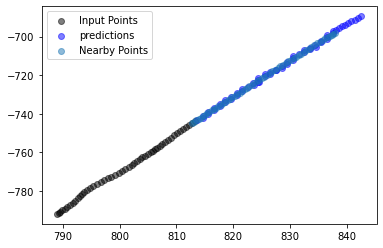

In [20]:
value = 5
plt.scatter(test_traj_in[value,:,0],test_traj_in[value,:,1],alpha=0.5, color="black",label="Input Points")
plt.scatter(predictions[value,:,0],predictions[value,:,1],alpha=0.5, color="blue",label="predictions")
plt.scatter(pa.iloc[value].values[1:].reshape(-1,2)[:,0], pa.iloc[value].values[1:].reshape(-1,2)[:,1],alpha=0.5,label="Nearby Points")
plt.legend()
plt.show()

In [180]:
sub = pd.read_csv("fifth_sub.csv")

In [181]:
sub

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-12.5975,-567.5975,-12.4975,-566.3975,-13.4975,-565.2975,-13.3975,-564.2975,-13.3975,...,-38.1600,-531.1600,-38.3775,-530.3775,-38.5900,-529.5900,-38.7975,-528.7975,-39.0000,-528.0000
1,1_austin,-344.4975,11.5025,-344.5975,10.5025,-344.5975,9.5025,-344.5975,9.6025,-343.3975,...,-312.6775,-0.6775,-312.0400,-1.0400,-311.3975,-1.3975,-310.7500,-1.7500,-310.0975,-2.0975
2,2_austin,51.2025,-247.9975,51.4100,-247.9900,51.6225,-247.9775,51.8400,-247.9600,52.0625,...,52.2025,-247.9975,52.4100,-247.9900,52.6225,-247.9775,52.2025,-247.9975,52.2025,-247.9975
3,3_austin,-113.5975,1798.4025,-113.1900,1798.8100,-112.7775,1799.2225,-112.3600,1799.6400,-111.9375,...,-83.7600,1828.2400,-83.0775,1828.9225,-82.3900,1829.6100,-81.6975,1830.3025,-81.0000,1831.0000
4,4_austin,1196.4025,-637.3975,1197.3025,-638.4975,1198.3025,-639.5975,1199.2025,-639.5975,1200.1025,...,1252.0025,-661.3975,1253.0025,-661.3975,1254.0025,-662.3975,1254.9025,-662.3975,1255.8025,-662.3975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,1681_palo-alto,-1391.5975,-478.1975,-1392.5975,-479.1975,-1393.5975,-480.1975,-1393.5975,-481.1975,-1394.5975,...,-1425.5975,-528.6975,-1425.5975,-529.6975,-1426.5975,-530.6975,-1426.4975,-531.6975,-1427.4975,-532.6975
29839,1682_palo-alto,129.4025,-21.3975,129.8100,-20.7900,130.2225,-20.1775,130.6400,-19.5600,131.0625,...,159.2400,19.4400,159.9225,20.3225,160.6100,21.2100,161.3025,22.1025,162.0000,23.0000
29840,1683_palo-alto,-1436.5975,2161.6025,-1436.5975,2160.6025,-1436.5975,2160.6025,-1435.4975,2160.6025,-1435.4975,...,-1409.5975,2140.5025,-1409.5975,2139.5025,-1409.5975,2139.5025,-1408.4975,2138.5025,-1408.4975,2138.6025
29841,1684_palo-alto,1071.5025,1398.5025,1072.0100,1399.0100,1072.5225,1399.5225,1073.0400,1400.0400,1073.5625,...,1115.6025,1433.6025,1115.6025,1433.6025,1116.6025,1434.6025,1116.6025,1434.5025,1117.7025,1435.5025


In [182]:
predictions = predictions.reshape(-1,120)

In [192]:
predictions.shape

(7971, 120)

In [183]:
import pandas as pd
sub_df = pd.DataFrame(predictions, columns = ["v" + str(i) for i in range(120)])

In [184]:
sub_df["ID"] = [str(i)+"_miami" for i in range(sub_df.shape[0])]
new_columns = sub_df.columns.tolist()[-1:] + sub_df.columns.tolist()[:-1]
sub_df = sub_df[new_columns]

In [191]:
sub[sub["ID"] == "0_miami"]

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
6325,0_miami,5922.605,1469.905,5922.22,1469.82,5921.845,1469.745,5921.48,1469.68,5921.125,...,5916.28,1480.08,5916.445,1480.545,5916.62,1481.02,5916.805,1481.505,5917.0,1482.0


In [195]:
sub[sub["ID"] == "7970_miami"]

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
14295,7970_miami,5759.405,1973.805,5759.82,1973.62,5760.245,1973.445,5760.68,1973.28,5761.125,...,5797.08,1978.48,5798.045,1978.845,5799.02,1979.22,5800.005,1979.605,5801.0,1980.0


In [200]:
sub.iloc[14296:]

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
14296,0_pittsburgh,4059.8050,207.9050,4059.6200,207.8200,4059.4450,207.7450,4059.2800,207.6800,4059.1250,...,4064.4800,218.0800,4064.8450,218.5450,4065.2200,219.0200,4065.6050,219.5050,4066.0000,220.0000
14297,1_pittsburgh,1479.4050,210.2050,1479.8200,210.4200,1480.2450,210.6450,1480.6800,210.8800,1481.1250,...,1517.0800,236.8800,1518.0450,237.6450,1519.0200,238.4200,1520.0050,239.2050,1521.0000,240.0000
14298,2_pittsburgh,1612.6050,361.5050,1612.2200,362.0200,1611.8450,362.5450,1611.4800,363.0800,1611.1250,...,1606.2800,404.6800,1606.4450,405.7450,1606.6200,406.8200,1606.8050,407.9050,1607.0000,409.0000
14299,3_pittsburgh,1590.6050,-169.5950,1590.2200,-169.1800,1589.8450,-168.7550,1589.4800,-168.3200,1589.1250,...,1584.2800,-131.9200,1584.4450,-130.9550,1584.6200,-129.9800,1584.8050,-128.9950,1585.0000,-128.0000
14300,4_pittsburgh,4478.4050,608.7050,4478.8200,609.4200,4479.2450,610.1450,4479.6800,610.8800,4480.1250,...,4516.0800,662.8800,4517.0450,664.1450,4518.0200,665.4200,4519.0050,666.7050,4520.0000,668.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,1681_palo-alto,-1391.5975,-478.1975,-1392.5975,-479.1975,-1393.5975,-480.1975,-1393.5975,-481.1975,-1394.5975,...,-1425.5975,-528.6975,-1425.5975,-529.6975,-1426.5975,-530.6975,-1426.4975,-531.6975,-1427.4975,-532.6975
29839,1682_palo-alto,129.4025,-21.3975,129.8100,-20.7900,130.2225,-20.1775,130.6400,-19.5600,131.0625,...,159.2400,19.4400,159.9225,20.3225,160.6100,21.2100,161.3025,22.1025,162.0000,23.0000
29840,1683_palo-alto,-1436.5975,2161.6025,-1436.5975,2160.6025,-1436.5975,2160.6025,-1435.4975,2160.6025,-1435.4975,...,-1409.5975,2140.5025,-1409.5975,2139.5025,-1409.5975,2139.5025,-1408.4975,2138.5025,-1408.4975,2138.6025
29841,1684_palo-alto,1071.5025,1398.5025,1072.0100,1399.0100,1072.5225,1399.5225,1073.0400,1400.0400,1073.5625,...,1115.6025,1433.6025,1115.6025,1433.6025,1116.6025,1434.6025,1116.6025,1434.5025,1117.7025,1435.5025


In [201]:
test = pd.concat([sub.iloc[0:6325], sub_df, sub.iloc[14296:]], ignore_index=True)

In [202]:
test

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-12.5975,-567.5975,-12.4975,-566.3975,-13.4975,-565.2975,-13.3975,-564.2975,-13.3975,...,-38.1600,-531.1600,-38.3775,-530.3775,-38.5900,-529.5900,-38.7975,-528.7975,-39.0000,-528.0000
1,1_austin,-344.4975,11.5025,-344.5975,10.5025,-344.5975,9.5025,-344.5975,9.6025,-343.3975,...,-312.6775,-0.6775,-312.0400,-1.0400,-311.3975,-1.3975,-310.7500,-1.7500,-310.0975,-2.0975
2,2_austin,51.2025,-247.9975,51.4100,-247.9900,51.6225,-247.9775,51.8400,-247.9600,52.0625,...,52.2025,-247.9975,52.4100,-247.9900,52.6225,-247.9775,52.2025,-247.9975,52.2025,-247.9975
3,3_austin,-113.5975,1798.4025,-113.1900,1798.8100,-112.7775,1799.2225,-112.3600,1799.6400,-111.9375,...,-83.7600,1828.2400,-83.0775,1828.9225,-82.3900,1829.6100,-81.6975,1830.3025,-81.0000,1831.0000
4,4_austin,1196.4025,-637.3975,1197.3025,-638.4975,1198.3025,-639.5975,1199.2025,-639.5975,1200.1025,...,1252.0025,-661.3975,1253.0025,-661.3975,1254.0025,-662.3975,1254.9025,-662.3975,1255.8025,-662.3975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,1681_palo-alto,-1391.5975,-478.1975,-1392.5975,-479.1975,-1393.5975,-480.1975,-1393.5975,-481.1975,-1394.5975,...,-1425.5975,-528.6975,-1425.5975,-529.6975,-1426.5975,-530.6975,-1426.4975,-531.6975,-1427.4975,-532.6975
29839,1682_palo-alto,129.4025,-21.3975,129.8100,-20.7900,130.2225,-20.1775,130.6400,-19.5600,131.0625,...,159.2400,19.4400,159.9225,20.3225,160.6100,21.2100,161.3025,22.1025,162.0000,23.0000
29840,1683_palo-alto,-1436.5975,2161.6025,-1436.5975,2160.6025,-1436.5975,2160.6025,-1435.4975,2160.6025,-1435.4975,...,-1409.5975,2140.5025,-1409.5975,2139.5025,-1409.5975,2139.5025,-1408.4975,2138.5025,-1408.4975,2138.6025
29841,1684_palo-alto,1071.5025,1398.5025,1072.0100,1399.0100,1072.5225,1399.5225,1073.0400,1400.0400,1073.5625,...,1115.6025,1433.6025,1115.6025,1433.6025,1116.6025,1434.6025,1116.6025,1434.5025,1117.7025,1435.5025


In [203]:
test.to_csv("sixth_sub.csv", index=None)